# Calculation of the R_eff numbers for Germany (overall and on regional level)

## Objective
To be able to understand and later foresee government decisions on lockdown measures, we need to look at the same metrics as governments do. Among others as active cases or intensive care units, this is also the (effective) reproduction number.

In Germany these numbers are calculated and published  by RKI. Unfortunately they do not share their code for calculation, so that we have to come up with our own calculation and compare our numbers with the RKI numbers.

The so established calculation procedure can then be applied globally to get an overview of the reproduction number in different regions worldwide.

## Data Source - RKI
What is special about the RKI data?

It has the patients linelist and the overall case numbers information combined. The data catalogue can be found here <<https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6>>

For the global calculation one needs to combine multiple datasources to get the same data, e.g. use the global linelist from beoutbreakprepared <<https://github.com/beoutbreakprepared/nCoV2019/tree/8b8a11a93f99a2814a809ab9b6a7bc0f94db576a/latest_data>> with data catalogue here <<https://www.nature.com/articles/s41597-020-0448-0>> in combination with Johns Hopkins casenumbers <<https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/>>.

## Calculation Procedure

The calculation of R_eff consists of multiple calculation

### Imputation

At first the datapoints with missing symptoms-onset date are imputed. Therefor for all datapoints for which we have the reporting and the symptoms onset date the reporting delay is calculated. Then a Weibull distribution is fitted for the reporting delay. This distribution is then applied to the datapoints with missing symptoms onset date for assigning a certain reporting delay to these datapoints and calculate the symptons onset date.

### Nowcasting

The same distribution is then used to adapt the casenumbers to account for possible cases which will be reported in the future with symptoms onset date until today.

### Rolling Window Ratio

The calculation of r_eff itself is performed as a summation of casenumbers within a certain timeperiod. RKI uses 4 days. Then the ratio of two sums is compared. Here RKI also compares the sums with 4 days inbetween.

## Comparison with official published numbers

RKI does not publish their code for calculating the r_eff numbers, but does publish the numbers itself (nowcasted and r_eff values). So we can compare and validate our calculation procedure.


Code Toggling

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

Imports

In [2]:
import pandas as pd
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min 
from datetime import date 
import ipywidgets as widgets
import difflib
import random
%matplotlib inline

hide_toggle()

Data Import of RKI data

In [3]:
# raw unprocessed data
df_rki=pd.read_csv("/project_data/data_asset/sun/casenumbers/rki_covid19.csv")
# processed data: summed over all "Landkreise" and sorted according to "Meldedatum"
df_rki_melde=pd.read_csv("/project_data/data_asset/mercury/casenumbers/RKI_ConfirmedCases_ReportingDate.csv")

hide_toggle()

Proove whether data is up-to-date

In [4]:
print(df_rki["Datenstand"].unique())

hide_toggle()

['03.07.2020, 00:00 Uhr']


Perform the logic check to get all new cases:

In [5]:
df_rki_temp = df_rki[((df_rki["NeuerFall"]==0) | (df_rki["NeuerFall"]==1))]

hide_toggle()

Just for visualization purposes: Plot the case numbers for each "Landkreis" (regional levl in Germany)

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


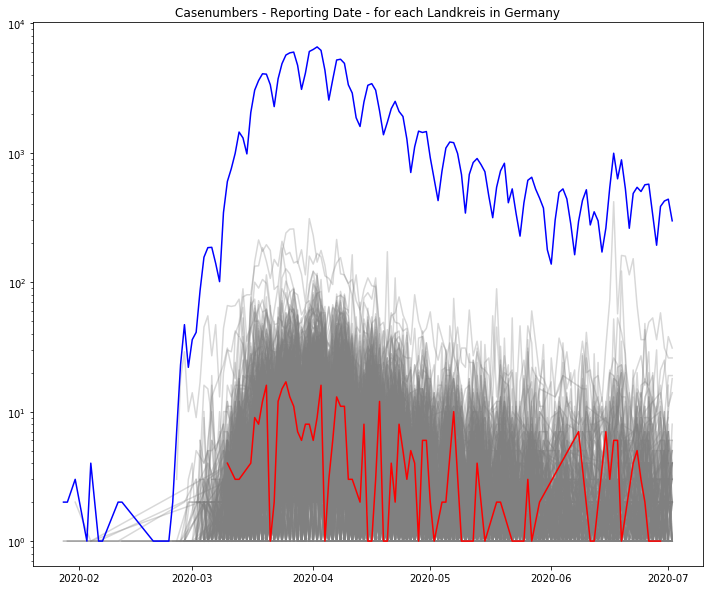

In [6]:
# Plotting the casenumbers
fig=plt.figure(figsize=(12,10))
ax1=fig.add_subplot(111)
#ax.xaxis.set_major_formatter(daysFmt)

df_rki_lk=df_rki_temp.groupby(["Landkreis","Meldedatum"],as_index=False)[["AnzahlFall"]].sum()
for i in df_rki_lk["Landkreis"].unique():
    df=df_rki_lk[df_rki_lk["Landkreis"]==i]
    df.set_index("Meldedatum", inplace=True, drop=True)
    df.index=pd.to_datetime(df.index,format="%Y-%m-%d")
    df.sort_index(inplace=True)
    ax1.plot(df["AnzahlFall"],color="grey",alpha=0.3)

    if "Berlin" in i:
        df_b=df

df_rki_melde.index=pd.to_datetime(df_rki_melde.index,format="%Y-%m-%d")
ax1.plot(df_rki_melde["AnzahlFall"],color="blue",label="Germany")
ax1.plot(df_b["AnzahlFall"],color="red",label="Berlin")
plt.yscale("log")
plt.title("Casenumbers - Reporting Date - for each Landkreis in Germany")
#plt.legend()

hide_toggle()

Setting the sliding window size for the R_eff calculation (RKI uses 4 days).

This value is used for the summation of cases (e.g. sum of cases 2020-04-05 - 2020-04-08) as well as for the calculation of the ratio (e.g. sum(2020-05-06)/sum(2020-05-09))

In [7]:
# set the timewindow for sliding window
# RKI uses 4 days:
window=widgets.IntSlider(
    value=4,
    min=0,
    max=10,
    step=1,
    description='Sliding time window',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(window)

hide_toggle()

IntSlider(value=4, continuous_update=False, description='Sliding time window', max=10)

Routine for padding the timeseries

In [8]:
# Routine for padding the timeseries

idx = pd.IndexSlice

date_index=pd.date_range(start='01/01/2020',end=date.today(),freq='D')

def filldates(df):
    df.reset_index(drop=True,inplace=True)
    df=df.asfreq("1D",fill_value=0.0).reindex(date_index,fill_value=0.0)
    return df

hide_toggle()

Routine to create a linelist from the RKI data

In [9]:
# Routine to create a linelist from the RKI data
def create_linelist(df_rki):
    HELP1=[]
    HELP2=[]
    for index,row in df_rki.iterrows():
        i=1
        while i<=row["AnzahlFall"]:
            HELP1.append(row["Meldedatum"])
            HELP2.append(row["Refdatum"])
            i+=1

    HELP1=pd.to_datetime(HELP1)
    HELP2=pd.to_datetime(HELP2)
    df_linelist=pd.DataFrame(columns=["Meldedatum","Erkrankungsdatum"],data=list(zip(HELP1,HELP2)))

    # list with only valid dates, delay > 0 days    
    df_linelist_clean=df_linelist[df_linelist["Meldedatum"]>df_linelist["Erkrankungsdatum"]]
    
    # Include the delay of 0 days for cases where we do not have the symptoms onset date.
    df_linelist.loc[:,"delay"]=df_linelist["Meldedatum"]-df_linelist["Erkrankungsdatum"]
    # to use for cw as a covariate!
    df_linelist.loc[:,"cw"]=[i.isocalendar()[1] for i in df_linelist["Meldedatum"]]

    # just for the cases where we do have both dates
    df_linelist_clean.loc[:,"delay"]=df_linelist_clean["Meldedatum"]-df_linelist_clean["Erkrankungsdatum"]
    # to use for cw as a covariate!
    df_linelist_clean.loc[:,"cw"]=[i.isocalendar()[1] for i in df_linelist_clean["Meldedatum"]]
    
    return df_linelist, df_linelist_clean

hide_toggle()

Routine for performing the imputation - Fitting Weibull Distribution for reporting delay, according to: https://www.medrxiv.org/content/10.1101/2020.03.18.20037473v1

In [10]:
# Routine for performing the imputation 
# Fitting Weibull Distribution
def imputation(df_linelist,df_linelist_clean):
    shape, loc, scale = weibull_min.fit(df_linelist_clean["delay"].dt.days, floc=0)
    wb_row=[name,shape,loc,scale]
    
# distribute missing values accordingly to that distribution:
# create random numbers and assign to the missing delay values in the dataframe:
# overall values
    size=len(df_linelist)
    r=weibull_min.rvs(shape,loc=loc,scale=scale,size=size)
    df_linelist.loc[:,"delay_weibull"]=[datetime.timedelta(days=int(i)) for i in r]
    df_linelist.loc[:,"Erkrankungsdatum Weibull"]=df_linelist["Meldedatum"]-df_linelist["delay_weibull"]
    #print(np.mean(df_linelist["delay_weibull"]))

# combine the known values with the imputated values:
    df_linelist.loc[df_linelist["delay"].dt.days<=0,"Combined"]=df_linelist.loc[df_linelist["delay"].dt.days<=0,"Erkrankungsdatum Weibull"]
    df_linelist.loc[df_linelist["delay"].dt.days>0,"Combined"]=df_linelist.loc[df_linelist["delay"].dt.days>0,"Erkrankungsdatum"]

    onset_combined=df_linelist["Combined"].value_counts()
    
# padding the timeseries data to get an entry for every day
    onset_combined.sort_index(inplace=True)
    onset_combined=onset_combined.asfreq("1D",fill_value=0.0).reindex(date_index,fill_value=0.0)
    
    number=max(df_linelist["delay"].dt.days)
    
# calculate p_delay for nowcasting routine
    p_delay=pd.Series(data=weibull_min.pdf(np.arange(0,number),shape,loc=loc,scale=scale),index=np.arange(0,number))
  
    return onset_combined,p_delay,wb_row

hide_toggle()

Nowcasting routine - taken from rt.live (https://github.com/k-sys/covid-19/blob/master/Realtime%20Rt%20mcmc.ipynb)

In [11]:
# Nowcasting Routine from rt.live

def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        mode="constant",
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay

hide_toggle()

Routine for performing the r_eff calculation

In [12]:
# Routine for performing the r_eff calculation
def calculate_reff(onset_adjusted):
    df_rolling=onset_adjusted.rolling(window.value).sum()
    r_t=df_rolling.pct_change(periods=window.value)+1.0
    r_t.sort_index(inplace=True)
    return r_t

hide_toggle()

Multicheckbox from github --> https://gist.github.com/pbugnion/5bb7878ff212a0116f0f1fbc9f431a5c

In [13]:
# multicheckbox from github

def multi_checkbox_widget(descriptions):
    """ Widget with a search field and lots of checkboxes """
    search_widget = widgets.Text()
    options_dict = {description: widgets.Checkbox(description=description, value=False) for description in descriptions}
    options = [options_dict[description] for description in descriptions]
    options_widget = widgets.VBox(options, layout={'overflow': 'scroll'})
    multi_select = widgets.VBox([search_widget, options_widget])

    # Wire the search field to the checkboxes
    def on_text_change(change):
        search_input = change['new']
        if search_input == '':
            # Reset search field
            new_options = [options_dict[description] for description in descriptions]
        else:
            # Filter by search field using difflib.
            close_matches = difflib.get_close_matches(search_input, descriptions, cutoff=0.0)
            new_options = [options_dict[description] for description in close_matches]
        options_widget.children = new_options

    search_widget.observe(on_text_change, names='value')
    return multi_select

hide_toggle()

Now the calculation procedure is performed for each Landkreis and the results (numbers and weibull coefficients) are stored in df's
- create linelist
- imputation
- nowcasting
- r_eff calculation

In [14]:
# do the complete calculation for all Landkreise:
data=[]
imputed=pd.DataFrame(index=date_index)
nowcast=pd.DataFrame(index=date_index)
r_eff=pd.DataFrame(index=date_index)

grouped=df_rki_temp.groupby("Landkreis")
for name, df in grouped:
    # create linelist
    df_linelist, df_linelist_clean = create_linelist(df)
    # perform imputation
    onset_combined,p_delay,wb_row = imputation(df_linelist,df_linelist_clean)
    # perform nowcasting
    onset_adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset_combined, p_delay)
    # calculate r_t
    r_t=calculate_reff(onset_adjusted)

    # add the Series data to the DataFrames
    imputed[name]=onset_combined
    nowcast[name]=onset_adjusted
    r_eff[name]=r_t
    data.append(wb_row)
    
# save the curve parameters to a dataframe    
df_wb=pd.DataFrame(columns=["LK","shape","loc","scale"],data=data)
df_wb=df_wb.set_index("LK")

hide_toggle()

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:1821: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


Do the calculation for all LK's in Berlin to get an overall result for Berlin

In [15]:
# do the calculation for Berlin:
lk=[i for i in df_rki_temp["Landkreis"].unique() if "Berlin" in i]
df=df_rki_temp[df_rki_temp["Landkreis"].isin(lk)] 
# create linelist
df_linelist, df_linelist_clean = create_linelist(df)
# perform imputation
onset_combined,p_delay,wb_row = imputation(df_linelist,df_linelist_clean)
# perform nowcasting
onset_adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset_combined, p_delay)
# calculate r_t
r_t=calculate_reff(onset_adjusted)
# add the Series data to the DataFrames
imputed["Berlin"]=onset_combined
nowcast["Berlin"]=onset_adjusted
r_eff["Berlin"]=r_t

hide_toggle()

Do the calculation for all LK's to get an overall result for Germany

In [17]:
# do the calculation for overall Germany:
# create linelist
df_linelist, df_linelist_clean = create_linelist(df_rki_temp)
# perform imputation
# this can also be done with calendar week as a covariate!
onset_combined,p_delay,wb_row = imputation(df_linelist,df_linelist_clean)
# perform nowcasting
onset_adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset_combined, p_delay)
# calculate r_t
r_t=calculate_reff(onset_adjusted)
# add the Series data to the DataFrames
imputed["Germany"]=onset_combined
nowcast["Germany"]=onset_adjusted
r_eff["Germany"]=r_t

hide_toggle()

Selection Checkbox for selection of LK's for plotting the r_eff values

In [18]:
select_plot = multi_checkbox_widget(nowcast.columns.values)

hide_toggle()

In [19]:
select_plot # Display the widget

Plot r_eff for the selected LK's

In [22]:
select_plot.children[1].children

(Checkbox(value=False, description='LK Ahrweiler'),
 Checkbox(value=False, description='LK Aichach-Friedberg'),
 Checkbox(value=False, description='LK Alb-Donau-Kreis'),
 Checkbox(value=False, description='LK Altenburger Land'),
 Checkbox(value=False, description='LK Altenkirchen'),
 Checkbox(value=False, description='LK Altmarkkreis Salzwedel'),
 Checkbox(value=True, description='LK Altötting'),
 Checkbox(value=False, description='LK Alzey-Worms'),
 Checkbox(value=False, description='LK Amberg-Sulzbach'),
 Checkbox(value=False, description='LK Ammerland'),
 Checkbox(value=False, description='LK Anhalt-Bitterfeld'),
 Checkbox(value=False, description='LK Ansbach'),
 Checkbox(value=False, description='LK Aschaffenburg'),
 Checkbox(value=False, description='LK Augsburg'),
 Checkbox(value=False, description='LK Aurich'),
 Checkbox(value=False, description='LK Bad Dürkheim'),
 Checkbox(value=False, description='LK Bad Kissingen'),
 Checkbox(value=False, description='LK Bad Kreuznach'),
 Ch

Berlin
Germany


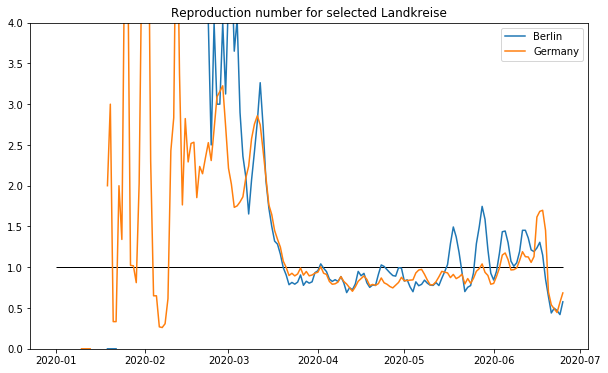

In [26]:
# for automated run within a job: set a default selection
names=["Berlin","Germany"]

#names=[w.description for w in select_plot.children[1].children if w.value]
fig, ax = plt.subplots(figsize=(10,6))
for name in names:
    print(name)
    ax.plot(r_eff.index,r_eff[name],label=name)
ax.hlines(y=1.0,xmin=min(r_eff.index),xmax=max(r_eff.index),lw=1.0)
plt.ylim([0,4])
plt.legend()
plt.title("Reproduction number for selected Landkreise")

hide_toggle()

## Evaluation / Validation / Visualization for Germany and Comparison with official published numbers

Import of published numbers (as of 2020-06-18) <<https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.html>>

In [53]:
# Vergleich mit nowcasting werten des RKI
df=pd.read_excel("/project_data/data_asset/Nowcasting_Zahlen_20200618.xlsx",sheet_name="Nowcast_R")

hide_toggle()

Visualization / Exploration for Germany's reporting delay

cases with given symptoms onset date:  127723
cases with missing symptoms onset date:  60041 31.97684327134062 %
delay mean: 6.884468733117763
delay median: 6.0
delay std 5.768248051384243
could be a lot of different curves for cw's


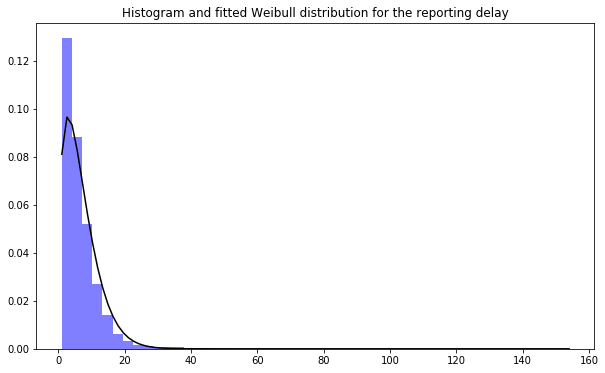

In [60]:
# Visualization / Exploration for Germany
print("cases with given symptoms onset date: ",len(df_linelist_clean))
print("cases with missing symptoms onset date: ",len(df_linelist)-len(df_linelist_clean),
     (len(df_linelist)-len(df_linelist_clean))/len(df_linelist)*100,"%")
plt.figure(figsize=(10,6))
plt.hist(df_linelist_clean["delay"].dt.days, density=True, alpha=0.5,bins=50,color="blue")
x = np.linspace(df_linelist_clean["delay"].dt.days.min(), df_linelist_clean["delay"].dt.days.max(), 100) 
plt.plot(x, weibull_min(wb_row[1], wb_row[2], wb_row[3]).pdf(x),color="black") 
plt.title("Histogram and fitted Weibull distribution for the reporting delay")
print("delay mean:",np.mean(df_linelist_clean["delay"].dt.days))
print("delay median:",np.median(df_linelist_clean["delay"].dt.days))
print("delay std",np.std(df_linelist_clean["delay"].dt.days))
print("could be a lot of different curves for cw's")

hide_toggle()

Now we do a plot to compare the reported cases with symptoms onset date with our imputed datasets
- using only the imputed dates (applying the weibull delay distribution to all datapoints)
- using a combination of reported cases and imputed datapoints, only when there was no symptons onset date given

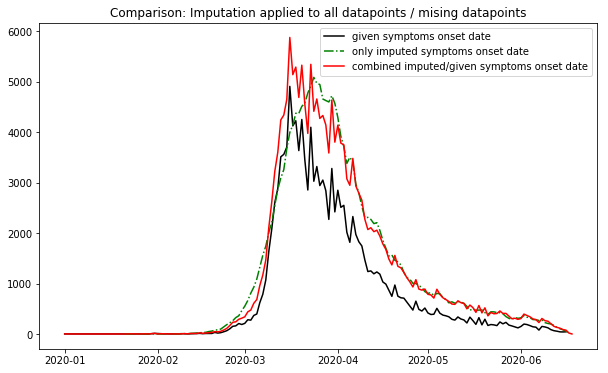

In [61]:
# plot the reported cases with onset symptoms date and the imputed
# compare with the nowcasted values from RKI:
onset_imputed=df_linelist["Erkrankungsdatum Weibull"].value_counts()
onset_real=df_linelist_clean["Erkrankungsdatum"].value_counts()
#onset_imputed_rki=df_rki_cw["Erkrankungsdatum Weibull"].value_counts()
onset_imputed.sort_index(inplace=True)
onset_real.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(onset_real, color="black", label="given symptoms onset date")
plt.plot(onset_imputed,"g-.", label="only imputed symptoms onset date")
plt.plot(onset_combined,color="red",label="combined imputed/given symptoms onset date")
plt.legend()
plt.title("Comparison: Imputation applied to all datapoints / mising datapoints")

hide_toggle()

We can see that it is no good fit when the imputation is applied to all datapoints, so we rather go with the combined dataset!

In the next plot we compare our nowcasted values (based on the combined imputed timeseries) with the nowcast values from RKI 

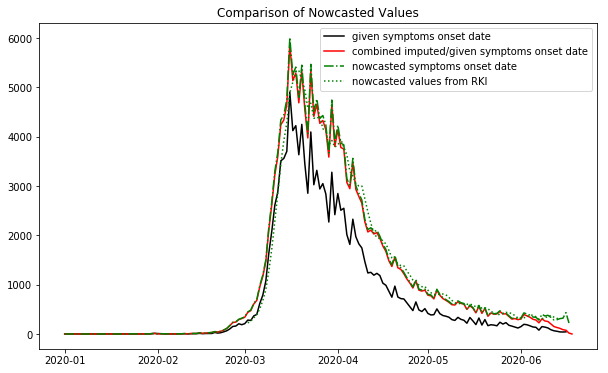

In [62]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(onset_real, color="black", label="given symptoms onset date")
plt.plot(onset_combined,color="red",label="combined imputed/given symptoms onset date")
plt.plot(onset_adjusted,"g-.", label="nowcasted symptoms onset date")
plt.plot(df["Datum des Erkrankungsbeginns"],df["Punktschätzer der Anzahl Neuerkrankungen"],"g:",label="nowcasted values from RKI")
plt.legend()
plt.title("Comparison of Nowcasted Values")

hide_toggle()

We can see a good fit between our values and the RKI values, so the applied methods seem to be correct.

Open questions are still:
- For how many cases does one need the symptoms onset date given to get a "valid" distribution.

In the next plot we take a look at the calculated r_eff and the RKI r_eff values

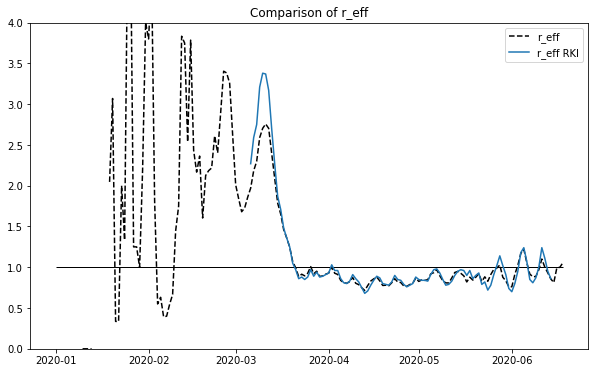

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(r_t,"k--",label="r_eff")
ax.plot(df["Datum des Erkrankungsbeginns"],df["Punktschätzer der Reproduktionszahl R"], label="r_eff RKI")
ax.hlines(y=1.0,xmin=min(r_eff.index),xmax=max(r_eff.index),lw=1.0)
plt.ylim([0,4])
plt.legend()
plt.title("Comparison of r_eff")

hide_toggle()

### Possible Extension: Perform the Weibull fitting with the calendar week as a covariate.
This takes into account, that the reporting routines and procedures do change during the pandemic

We rerun the part for overall Germany, and just using another routine for the fitting the Weibull distribution.

In the created linelists we already introduced another column for the calendarweek, of which we can make use now.

Then we plot all Weibull curves for all calendar weeks to the deviation.

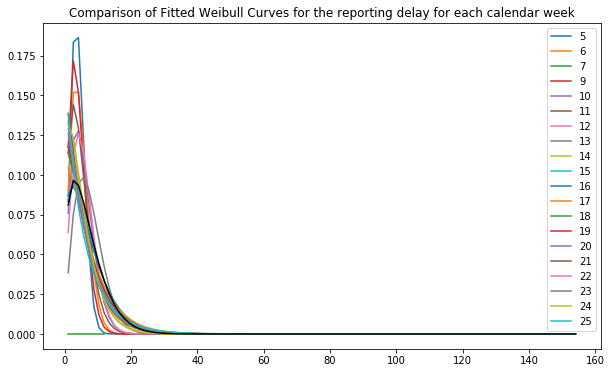

In [78]:
# do the calculation for overall Germany - with calendar week as covariate:
# create linelist
df_linelist, df_linelist_clean = create_linelist(df_rki_temp)

# fit Weibull distributions for every calendar week
data=[]
grouped=df_linelist_clean.groupby("cw")
for name,group in grouped:
    shape, loc, scale = weibull_min.fit(group["delay"].dt.days, floc=0)
    row=[name,shape,loc,scale]
    data.append(row)

# dataframe with Weibull coefficients for every calendar week
df_wb=pd.DataFrame(columns=["cw","shape","loc","scale"],data=data)
df_wb=df_wb.set_index("cw")

# just for comparison: Weibull shape parameters for overall data (redoing the former calculation)
shape_ges, loc_ges, scale_ges = weibull_min.fit(df_linelist_clean["delay"].dt.days, floc=0)

# plot the curves
x = np.linspace(df_linelist_clean["delay"].dt.days.min(), df_linelist_clean["delay"].dt.days.max(), 100) 
fig, ax = plt.subplots(figsize=(10,6))
for row in df_wb.iterrows():
    ax.plot(x, weibull_min(row[1][0], row[1][1],row[1][2]).pdf(x),label=row[0])
ax.plot(x, weibull_min(shape_ges, loc_ges, scale_ges).pdf(x),color="black") 
plt.legend()
plt.title("Comparison of Fitted Weibull Curves for the reporting delay for each calendar week")

hide_toggle()

Save the dataframes for imputed / nowcasted and r_eff numbers for all Landkreise in Germany

In [33]:
import pickle
def save_obj(obj, name):
    with open('/project_data/data_asset/venus/r_eff_numbers_germany/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/project_data/data_asset/venus/r_eff_numbers_germany/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
hide_toggle()

In [34]:
save_obj(imputed,"imputed")
imputed.to_csv("/project_data/data_asset/venus/r_eff_numbers_germany/imputed.csv",index_label=False)
#imputed=load_obj("imputed")

In [35]:
save_obj(nowcast,"nowcast")
nowcast.to_csv("/project_data/data_asset/venus/r_eff_numbers_germany/nowcast.csv",index_label=False)
#nowcast=load_obj("nowcast")

In [36]:
save_obj(r_eff,"r_eff")
r_eff.to_csv("/project_data/data_asset/venus/r_eff_numbers_germany/r_eff.csv",index_label=False)
#r_eff=load_obj("r_eff")

In [37]:
save_obj(df_wb,"df_wb")
df_wb.to_csv("/project_data/data_asset/venus/r_eff_numbers_germany/df_wb.csv",index_label=False)
#r_eff=load_obj("df_wb")